In [54]:
# pandas
import pandas as pd

# nltk for tokenization
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize

# spacy for entity rec
import spacy

In [55]:
nlp = spacy.load('en_core_web_sm')

In [15]:
'''
Read in .txts/.csvs of tagged sample data as a Pandas data frame
Add appropriate header to the columns as well.
'''
def read_as_df(buckets_filename, claim_id_filename, passage_filename):
    claim_ids = pd.read_csv(claim_id_filename, sep="\n")
    buckets = pd.read_csv(buckets_filename, sep="\n")
    passages = pd.read_csv(passage_filename, sep="\n")
    df_col_merged = pd.concat([claim_ids, buckets, passages], axis=1)

    return df_col_merged

In [16]:
merged = read_as_df('data/relic_prev_buckets.txt', 'data/relic_prev_ids.csv', 'data/relic_prev_passages.txt')

In [17]:
merged.head()

,claim_id,bucket,passage
0,13861,metaphor,The work of one moment was destroyed by the next.
1,55809,metaphor,How should they learn the entry into the finer...
2,3193,metaphor,What is the meaning of life?
3,18123,internal character experience,His mind pictured the soldiers who would place...
4,18448,embellishing an event,He yelled then with fright and swung about. Fo...


In [22]:
def get_word_count(passage):
    return len(word_tokenize(passage))

In [32]:
def get_sentence_count(passage):
    return len(sent_tokenize(passage))

In [63]:
def get_entity_count(passage):
    doc = nlp(passage)
    return len(doc.ents)

In [64]:
# tally word count for each passage
merged['word_count'] = merged.apply(lambda x: get_word_count(x.passage), axis=1)

In [33]:
# tally sentence count for each passage
merged['sentence_count'] = merged.apply(lambda x: get_sentence_count(x.passage), axis=1)

In [66]:
# tally named entity count for each passage
merged['named_entity_count'] = merged.apply(lambda x: get_entity_count(x.passage), axis=1)

In [85]:
# word count per group
merged.groupby(['bucket'])['word_count'].median()

bucket
embellishing an event            1.0
external characterization        2.0
informative detail               2.0
internal character experience    2.0
metaphor                         1.0
sensory detail                   2.0
x                                1.0
Name: sentence_count, dtype: float64

In [83]:
# 5th percentile
merged['word_count'].quantile(0.05)

13.0

In [84]:
# 95th percentile
merged['word_count'].quantile(0.95)

121.0

In [74]:
# entity count per group
merged.groupby(['bucket'])['named_entity_count'].mean()

bucket
embellishing an event            0.947368
external characterization        0.875706
informative detail               1.492386
internal character experience    0.516129
metaphor                         0.899281
sensory detail                   1.039370
x                                0.802260
Name: named_entity_count, dtype: float64

<AxesSubplot:>

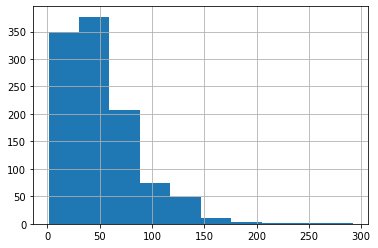

In [78]:
merged['word_count'].hist()

<AxesSubplot:>

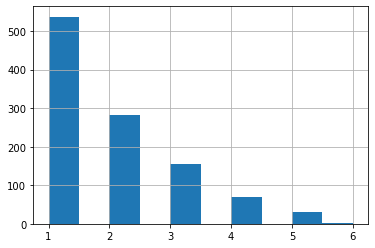

In [43]:
merged['sentence_count'].hist()

In [89]:
# sentence count per group
merged.groupby(['bucket'])['sentence_count'].mean()

bucket
embellishing an event            1.939850
external characterization        1.751412
informative detail               1.928934
internal character experience    1.927419
metaphor                         1.640288
sensory detail                   2.023622
x                                1.875706
Name: sentence_count, dtype: float64

In [77]:
merged.sort_values(by=['word_count'], ascending=False).head(30)[['passage', 'word_count']]

,passage,word_count
334,There was one among them which was a tall pane...,292
363,then you saw a lifeboat full of children with ...,251
885,In the hardest working part of Coketown; in th...,207
741,"it passed thus close by me, in action, so to s...",190
610,"After the first glance, there were slight feat...",179
735,"secondly, if it should appear that the conditi...",178
708,"And Clyde, as instantly sensing the profoundne...",178
266,In bed we concocted our plans for the morrow. ...,165
191,17 It was a picturesque old house in a fine pa...,161
498,The moment when a man's head drops off is seld...,155


In [100]:
list(merged[merged['word_count'] < 13.0]['passage'])

['The work of one moment was destroyed by the next.',
 'What is the meaning of life?',
 'Carrie realised the change of affectional atmosphere at once.',
 'I am tied down with single words.',
 'A display!',
 'but spectral, not really existing.',
 'WHY should human equality be averted?',
 "It wasn't a scene for a shudder;",
 'A bird twittered; two birds, three.',
 'x',
 'The verdict of human nature on such a wretch was death.',
 'She possessed eyes whose gaze I delighted to encounter.',
 'It most froze me to hear such talk.',
 'All men live enveloped in whale-lines.',
 'I opened the glass-door in the breakfast-room:',
 'Sailors loiter on the parade, and amorous couples;',
 'She had thought him just the bright reflex of herself.',
 'Would they but love her, she should be satisfied.',
 'All here is false; all is meretricious.',
 'he is a tyrant; he wears Mrs. Ramsay to death;',
 "it's Cana of Galilee, the first miracle....",
 'It would have hurt her if he had refused to come.',
 'Silent an

In [99]:
len(list(merged[merged['word_count'] > 121]['claim_id']))

53